In [974]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, math, heapq
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import re, urllib

utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
sys.path.append(BASE_DIR)
subreddit_id = "2qh13"

ARCHIVE_DIR = "/home/nathan/reddit_archive/03.2017"

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction, Experiment
from utils.common import PageType

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")
#r = conn.connect()

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')



# Estimating Interference on AI Nudge Study Rankings with an Interrupted Timeseries

In [975]:
experiment_begin = "2016-11-27 17:04:19"
experiment_end_date = '2017-02-18 00:00:00'
post_experiment_end_date = '2017-04-18 00:00:00'
post_experiment_end_date_daylater = '2017-04-19 00:00:00'
three_hundred_begin_date = utc.localize(datetime.datetime.utcfromtimestamp(1484340430.0))

In [976]:
tabloid_domains = [ 'dailymail.co.uk', 'express.co.uk','mirror.co.uk', 'news.com.au', 
                    'nypost.com', 'thesun.co.uk','dailystar.co.uk','metro.co.uk']
msm_domains     = [ "bbc.com", "reuters.com", "nytimes.com", "washingtonpost.com", "cnn.com", 
                    "telegraph.co.uk", "latimes.com", "huffingtonpost.com", "theguardian.com", "forbes.com",
                    "examiner.com", "usatoday.com", "wsj.com", "cbsnews.com", "cbc.ca", "time.com",
                    "sfgate.com", "newsweek.com", "bostonglobe.com", "nydailynews.com", "msnbc.com",
                    "foxnews.com", "aljazeera.com", "nbcnews.com", "npr.org", "bloomberg.com", "abcnews.com", 
                    "aljazeera.com", "bigstory.ap.com", "cbc.ca", "time.com"]

omitted_matches = ["reddit", "img", "image", "giphy", "quickmeme"]

bots = ['autotldr', 'Mentioned_Videos', 'DailMail_Bot', 'youtubefactsbot', 'HelperBot_']


post_creation = {}
all_posts = {}
query_text = """
select * from experiment_things 
    JOIN posts ON experiment_things.id = posts.id 
    WHERE experiment_id=8 
    AND object_type=1
    AND posts.created_at <= '{experiment_end_date}'
    ORDER BY posts.created ASC;
""".format(experiment_end_date=experiment_end_date)

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

for row in db_engine.execute(text(query_text)):
    post = {}
    post_data = json.loads(row['post_data'])    
    for key in post_data.keys():
        post[key] = post_data[key]
    for key in row.keys():
        post[key]=row[key]
    del post['post_data']
    
    post_created = utc.localize(datetime.datetime.utcfromtimestamp(float(post['created_utc'])))
    post_creation[post['id']] = post_created
    post['created']  = post_created
    post['visible'] = True
    post['origin'] = "experiment.thing"
    post['within.experiment.period'] = True
    all_posts[post['id']] = post

#print(len(snapshotted_posts))
print("Found {0} posts".format(len(all_posts)))

Found 1273 posts


/home/nathan/3venv/lib/python3.5/site-packages/sqlalchemy/dialects/mysql/base.py:2513: Warning: '@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead
  cursor.execute('SELECT @@tx_isolation')


### Set Date Boundaries

In [977]:
# experiment = {}
# for row in db_engine.execute(text("select name, created_at, id FROM experiments WHERE name='sticky_comment_multiarm_worldnews_0';")):
#     for key in row.keys():
#         experiment[key] = row[key]
# print("Earliest Date: {0}".format(all_posts[0]['created_at']))
earliest_date = min([x['created_at'] for x in list(all_posts.values())])
latest_date = max([x['created_at'] for x in list(all_posts.values())])

## USED TO FOLLOW THE RANKINGS FOR ANOTHER DAY
ranking_latest_date = max([x['created_at'] for x in list(all_posts.values())]) + datetime.timedelta(days=1)
post_experiment_latest_date = parser.parse(post_experiment_end_date)
#front_page_latest_date =  max([x['created_at'] for x in list(all_posts.values())]) + datetime.timedelta(days=60)

# print("Experiment Date: {0}".format(experiment['created_at']))
# print("Latest Date: {0}".format(all_posts[-1]['created_at']))

## Collect Posts
### Collect Posts from the Period After the Study

In [978]:
query_text = """
select * FROM posts 
    WHERE subreddit_id = '{subreddit_id}' 
    AND posts.created_at >= '{experiment_end_date}'
    AND posts.created_at <= '{post_experiment_end_date}'
    ORDER BY posts.created ASC;
""".format(subreddit_id = subreddit_id,
           experiment_end_date = experiment_end_date,
           post_experiment_end_date = post_experiment_end_date)

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY
added_posts = 0 
for row in db_engine.execute(text(query_text)):
    post = {}
    post_data = json.loads(row['post_data'])
    eligible_post = False
    
    post_created = utc.localize(datetime.datetime.utcfromtimestamp(float(post_data['created_utc'])))
    post_creation[post_data['id']] = post_created
    
    for domain in tabloid_domains:
        if(post_data['url'].find(domain)>-1):
            eligible_post = True
            break
    if(eligible_post):
        for key in post_data.keys():
            post[key] = post_data[key]
        for key in row.keys():
            post[key]=row[key]
        del post['post_data']
        post['visible'] = True
        post['origin'] = 'post.query'
        post['within.experiment.period'] = False
        all_posts[post['id']] = post
        added_posts += 1

#print(len(snapshotted_posts))
print("Found {0} eligible posts".format(added_posts))

Found 938 eligible posts


### Collect Posts from Baumgartner's Dataset

In [979]:
## ELIGIBLE POSTS
file_posts = {}
files_to_load = []

for filename in glob.glob(os.path.join(ARCHIVE_DIR,"posts","*")):
    basename = os.path.basename(filename).split(".")
    month = basename[2]
    year = basename[3]
    if((int(year)==2016 and int(month) >= earliest_date.month) or 
       (int(year)==2017) and int(month) <= post_experiment_latest_date.month):
        files_to_load.append(filename)

counter = 0
for filename in files_to_load:
    with open(filename, "r") as f:
        #print(filename)
        for line in f:
            if(line.find(subreddit_id)>-1):
                post = json.loads(line)                
                post_created = utc.localize(datetime.datetime.utcfromtimestamp(float(post['created_utc'])))
                post_creation[post['id']] = post_created
                
                if('subreddit_id' in post.keys() and post['subreddit_id']=="t5_" + subreddit_id):
                    eligible_post = False
                    post['created'] = post_created
                    post_creation[post['id']] = post_created
                    
                    for domain in tabloid_domains:
                        if(post['url'].find(domain) > -1):
                            eligible_post = True
                    if(eligible_post):
                        post['within.experiment.period'] = False
                        post['visible'] = True ## ASSIGN VISIBILITY
                        post['origin'] = "json.file"
                        if(post_created > utc.localize(earliest_date) and 
                           post_created <= utc.localize(post_experiment_latest_date)):
                            post['within.experiment.period'] = True
                            if(post_created > utc.localize(parser.parse(experiment_end_date))):
                                post['within.experiment.period'] = False
                            file_posts[post['id']] = post
        counter +=1
        sys.stdout.write(".")
        sys.stdout.flush()
print("Processed {0} files. {1} posts loaded in total. {2} added to post_creation".format(counter, len(file_posts), len(post_creation)))

................................................................................................................................................................................Processed 176 files. 2790 posts loaded in total. 208835 added to post_creation


### Merge Posts

In [992]:
merged_posts=0
for key, post in file_posts.items():
    if key not in all_posts.keys():
        all_posts[key] = post
        merged_posts +=1
print("Merged {0} posts".format(merged_posts))

Merged 0 posts


## Check Time Overlaps

In [993]:
# #post_creation = {}
missed_rows = 0
retrieved_rows = 0
time_diffs = []
for row in db_engine.execute(text("select * from posts WHERE subreddit_id = '2qh13' AND created_at > '{0}' AND created_at < '{1}';".format(
   earliest_date,
   post_experiment_latest_date))):
    
    if(row['id'] in post_creation.keys() and row['id'] in all_posts.keys()):
        post = json.loads(row["post_data"])
        created_at = utc.localize(datetime.datetime.utcfromtimestamp(float(post['created_utc'])))
        time_diffs.append({"diff":(created_at - post_creation[row['id']]).total_seconds()/60,
                           "origin":all_posts[row['id']]['origin']})
    else:
        missed_rows += 1
    retrieved_rows += 1
        #   post_creation[row['id']] = row['created']
print("Retrieved {0} rows and missed {1} rows".format(retrieved_rows, missed_rows))

Retrieved 66977 rows and missed 64697 rows


/home/nathan/3venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


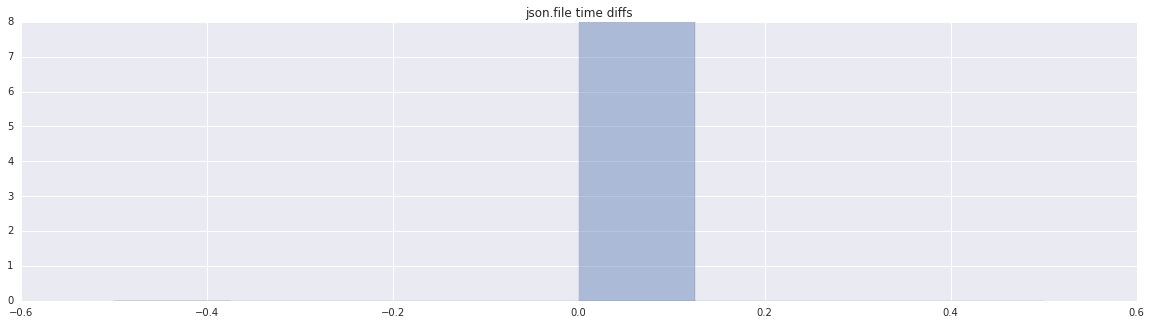

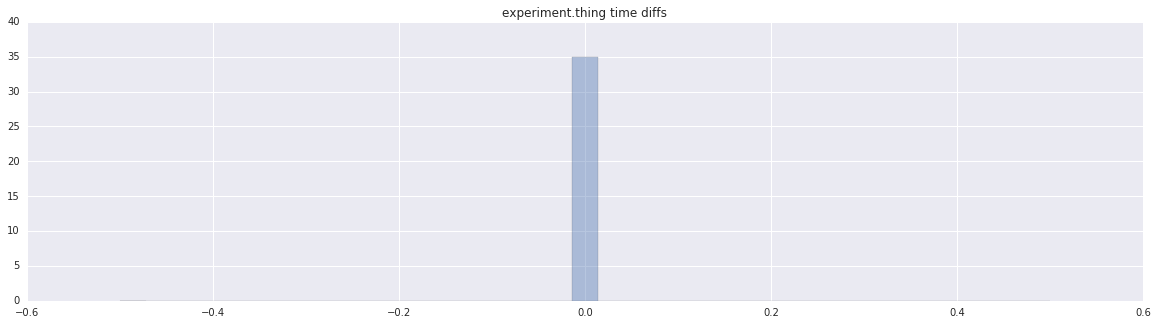

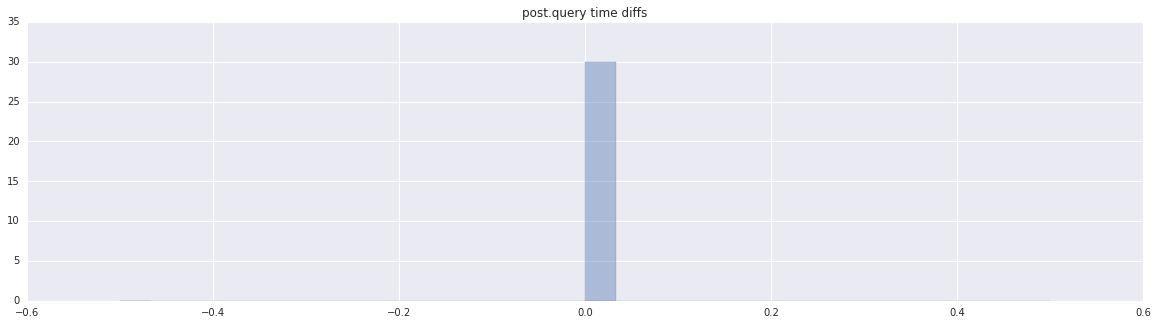

In [994]:
prs = [x['diff'] for x in time_diffs if x['origin']=='json.file']
plt.figure(figsize=(20,5))
sns.distplot(prs)
plt.title("json.file time diffs")
plt.show()

prs = [x['diff'] for x in time_diffs if x['origin']=='experiment.thing']
plt.figure(figsize=(20,5))
sns.distplot(prs)
plt.title("experiment.thing time diffs")
plt.show()

prs = [x['diff'] for x in time_diffs if x['origin']=='post.query']
plt.figure(figsize=(20,5))
sns.distplot(prs)
plt.title("post.query time diffs")
plt.show()

In [995]:
## TODO BELOW: BE SURE THAT THE START AND END TIMES CORRESPOND PROPERLY TO THE TIMEZONES

## Get Subreddit Rankings Data

In [996]:
def timediff_minutes(timediff):
    try:
        return timediff.total_seconds()/60
    except:
        return None
    
post_rankings = defaultdict(list)

ranking_records = []
ranking_snapshot_number = 0

missing_post_ids = set()

page_lengths = []

prev_created_at = None

posts_with_no_age = set()

for page in db_engine.execute(text("select * from subreddit_pages WHERE subreddit_id='2qh13' AND page_type={0} AND created_at > '{1}' AND created_at < '{2}';".format(
    4, #PageType.HOT
    earliest_date,
    post_experiment_end_date_daylater
))):
    posts = json.loads(page['page_data'])
    median_score = np.median([x['score'] for x in posts])
    post_ages = []
    
    page_created = utc.localize(page.created_at)
        
    for post in posts:
        #post_created = utc.localize(datetime.datetime.utcfromtimestamp(post['created_utc']))
        try:
            age = page_created - post_creation[post['id']]
        except:
            age = None 
            missing_post_ids.add(post['id'])
#             submission = r.get_submission(submission_id = post['id'])
#             if(submission):
#                 age = page.created_at - datetime.datetime.utcfromtimestamp(submission.created_utc)
#             else:
#                 age = None
        post_ages.append(timediff_minutes(age))
    
    ### FOR NOW OMIT MEDIAN AGE IF THERE'S MISSING INFO
    try:
        median_age = np.median(post_ages)
    except:
        median_age = None
    
    
    position = 300

    ### limit to the first 100 items
    ### since we don't have 300 
    ### until much later
        
    for post in posts[0:300]:
        try:
            age = timediff_minutes(page_created - post_creation[post['id']])
        except:
            age = None
            posts_with_no_age.add(post['id'])
            
        snapshot = {"created_at":page_created,
                    "post.created": post_creation[post['id']],
                    "snapshot.length":len(posts),
                    "position":position,
                    "median.score":median_score,
                    "median.age":median_age,
                    "post.score":post['score'],
                    "post.age": age,
                    "snapshot.comments":post['num_comments'],
                    "post.id":post['id'],
                    "ranking.snapshot": ranking_snapshot_number}
        post_rankings[post['id']].append(snapshot)
        position -= 1
        
    try:
        minutes_since_last = (page_created - prev_created_at).total_seconds() / 60.0
    except:
        minutes_since_last = None
    
    ## CREATE A RANKING SNAPSHOT RECORD
    ranking_records.append({
            "created_at"      : page_created,
            "minutes.since.last"   : minutes_since_last,
            "ranking.snapshot":ranking_snapshot_number,
            "snapshot.length" : len(posts),
            "median.score"    : median_score,
            "median.age"      : median_age,
            "three.hundred.begin" : three_hundred_begin
        })
    ## ITERATE THE RANKING RECORD
    ranking_snapshot_number += 1
    prev_created_at = page_created

print("Acquired {0} ranking records".format(len(ranking_records)))

Acquired 50544 ranking records


(TODO: Update ranking times to deal with the timezone adjustment made to the CivilServant code in mid-December 2016)

/home/nathan/3venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


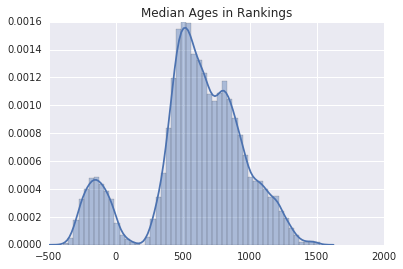

In [997]:
### TODO: FIGURE OUT WHY THERE ARE NEGATIVE AGES HERE
sns.distplot([x['median.age'] for x in ranking_records])
plt.title("Median Ages in Rankings")

# Collect Moderation Actions And Associate With Posts

In [998]:
recent_mod_actions = []
for row in db_engine.execute(text("""
SELECT subreddit_id, action_data FROM mod_actions 
    WHERE subreddit_id="2qh13" 
    AND created_utc >= "{experiment_begin}" 
    AND created_utc <=  "{post_experiment_end_date_daylater}";
""".format(
            experiment_begin=experiment_begin,
            post_experiment_end_date_daylater = post_experiment_end_date_daylater))):
    if(row['subreddit_id']=='2qh13'):
        mod_action = json.loads(row['action_data'])
        mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
        recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

401838 moderator actions loaded


In [999]:
post_mod_actions = defaultdict(list)
for action in recent_mod_actions:
    if action['action'] in ["removelink", 'approvelink']:
        key = action['target_fullname'].replace("t3_","")
        post_mod_actions[key].append({"created": action['created'],
                                      "action": action['action']})
### Now sort all mod actions per post
for key, post in post_mod_actions.items():
    post = sorted(post, key=lambda k: k['created'])

# Check the Integrity of the Dataset Assembled So Far

In [1000]:
ranking_times = [x['created_at'] for x in list(post_rankings.values())[8]]
time_diffs = []
for i in range(len(ranking_times)-1):
    i += 1
    time_diffs.append((ranking_times[i] - ranking_times[i-1]).total_seconds()/60.)
time_diffs

[4.466666666666667,
 3.55,
 4.0,
 4.066666666666666,
 4.033333333333333,
 4.316666666666666,
 3.6166666666666667,
 3.9833333333333334,
 3.933333333333333,
 4.1,
 4.0,
 4.0,
 3.9833333333333334,
 4.066666666666666,
 3.9,
 4.033333333333333,
 4.333333333333333,
 3.716666666666667,
 3.966666666666667,
 4.033333333333333,
 4.5,
 3.4166666666666665,
 4.1,
 4.0,
 3.933333333333333,
 4.116666666666666,
 3.966666666666667,
 3.9,
 4.1,
 3.9,
 4.1,
 4.316666666666666,
 3.6666666666666665,
 4.033333333333333,
 4.0,
 4.533333333333333,
 3.45,
 4.033333333333333,
 3.9,
 4.1,
 4.05,
 3.966666666666667,
 3.9,
 4.033333333333333,
 3.966666666666667,
 4.133333333333334,
 4.016666666666667,
 4.3,
 3.7,
 4.083333333333333,
 4.416666666666667,
 3.4833333333333334,
 4.0,
 3.966666666666667,
 3.966666666666667,
 4.066666666666666,
 4.0,
 3.9833333333333334,
 4.033333333333333,
 3.95,
 4.0,
 4.0,
 4.433333333333334,
 3.966666666666667,
 4.1,
 4.116666666666666,
 3.4166666666666665,
 4.016666666666667,
 3.933

# Create a Dataset of Post Rankings For the Period Covering 300 Ranking Items

### Calculate Mean Time Distance Between Snapshots

In [1001]:
mean_mins_since_last = math.floor(np.mean([x['minutes.since.last'] for x in ranking_records if x['minutes.since.last']!=None]))
maximum_minutes = 7*60 #seven hours (as specified in the paper)
num_snapshots = math.floor(maximum_minutes/mean_mins_since_last)

In [1014]:
rankings_added = []
posts_processed = 0

posts_with_negative_ranking_ages = []

added_post_ages = []

for key, post in all_posts.items():
    try:
        post_created = utc.localize(post['created'])
        post['created'] = post_created
    except:
        post_created = post['created']
    
    if(post_created < three_hundred_begin_date):
        post['rankings'] = []
        continue
    
    ## FOR NOW, OMIT RANKINGS LESS THAN 0
    rankings = [x for x in post_rankings[key] if x['post.age']>=0]
    
    ## DIAGNOSTIC TO FIND POSTS WITH NEGATIVE RANKINGS
    if(key in post_rankings.keys() and len(post_rankings[key])>0 and post_rankings[key][0]['post.age']<0):
        posts_with_negative_ranking_ages.append(post)
        
    minute_slots = [None for x in list(range(num_snapshots))]
    
    
    total_rankings_added = 0
    if(len(rankings)>0):        
        #first_ranking_slot = math.floor(rankings[0]['post.age']/4.0)
        #current_ranking_slot = first_ranking_slot 
        for ranking in rankings:
            current_ranking_slot = math.floor(rankings[0]['post.age']/4.0)
            if(current_ranking_slot < len(minute_slots)):
                ranking_record = copy.copy(ranking)                
                ranking_record['post.age'] = ranking_record['created_at']  - post_created
                ranking_record['post.created'] = post_created
                minute_slots[current_ranking_slot] = ranking_record
                total_rankings_added += 1
                
                added_post_ages.append(ranking_record['created_at']  - post_created)
                
    
    
    records_index = 0
    for record in ranking_records:
        try:
            greater = record['created_at'] >= utc.localize(post['created'])
        except:
            greater = record['created_at'] >= post['created']
        if greater:
            break
        records_index += 1
    
    i = 0
    for slot in minute_slots:
        if slot is None:
            slot = copy.copy(ranking_records[records_index])
            slot['position'] = 0
#            total_rankings_added += 1
            minute_slots[i] = slot
            
        records_index += 1
        i+=1
        
    rankings_added.append(total_rankings_added)
    
    snapshot_number = 1
    for slot in minute_slots:
        slot['snapshot.number'] = snapshot_number
        snapshot_number += 1

    post['rankings'] = minute_slots
    posts_processed +=1

    
#     if(posts_processed ==2):
#         break
print("Processed {0} posts".format(posts_processed))

Processed 1835 posts


In [1015]:
Counter([len(x['rankings']) for x in all_posts.values()])

Counter({0: 956, 105: 1835})

/home/nathan/3venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


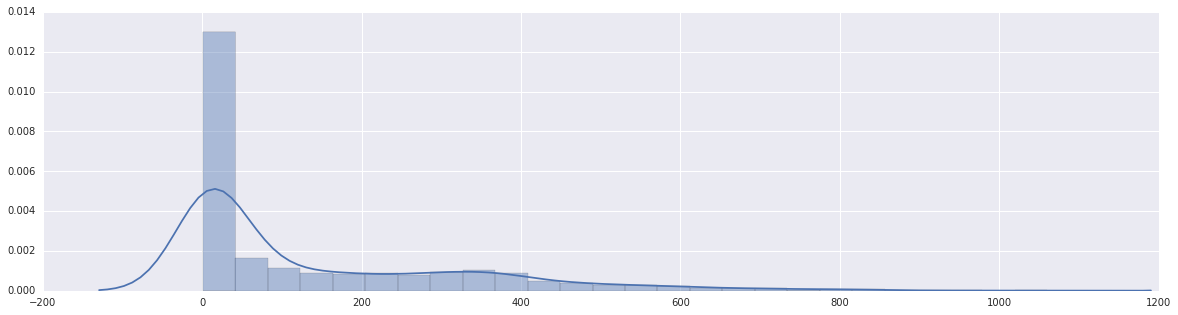

In [1003]:
plt.figure(figsize=(20,5))
sns.distplot([x for x in rankings_added if x>0])

### Analyze posts with negative ranking ages
(no longer a problem, now that I'm ignoring items from when we were observing 100 ranking items, which also fell in a period when we incompletely fixed timezone issues)

In [1004]:
#sns.distplot([x.total_seconds()/6.0 for x in added_post_ages])
#posts_with_negative_ranking_ages[1]
#len(posts_with_negative_ranking_ages)

In [1005]:
#total_rankings_added
#len(posts_with_negative_ranking_ages)
#minute_slots
#greater
#minute_slots
#minute_slots
#utc.localize(datetime.datetime.utcfromtimestamp(1484340430))

In [1006]:
#print(earliest_date)
#sns.distplot([(x['created'] - utc.localize(earliest_date)).total_seconds()/86400 for x in posts_with_negative_ranking_ages])

In [1007]:
# negative_median_ages = 0
# for post in list(all_posts.values()):
#     for ranking in post['rankings']

### Plot first time difference, and in the future, figure out why some of time differences are -10  hours

In [1008]:
first_rankings = []
for key, post in all_posts.items():
    if(post['created'] < three_hundred_begin_date):
        continue
    rankings = post_rankings[key]
    if(len(rankings)>0):
        first_rankings.append({"post.origin":post['origin'], 
                               "first.post.age":rankings[0]['post.age']})

938


/home/nathan/3venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


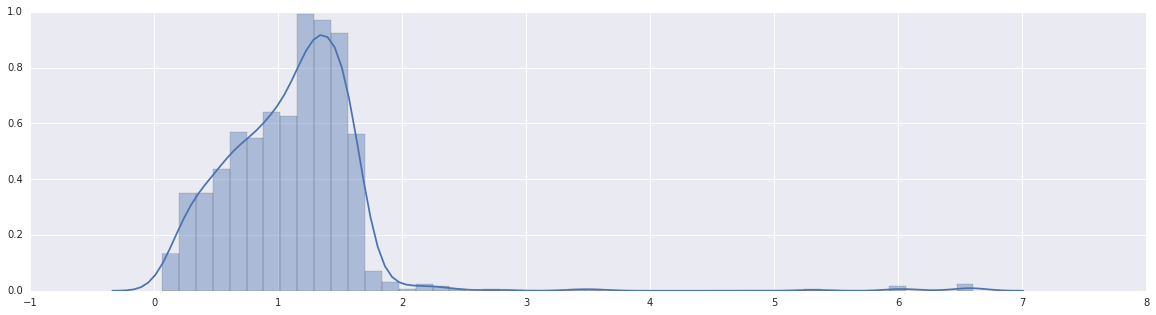

In [1009]:
prs = [math.log1p(x['first.post.age']) for x in first_rankings if x['post.origin']=='post.query']
print(len(prs))
plt.figure(figsize=(20,5))
post_ages = prs
sns.distplot(post_ages)
plt.show()

40


/home/nathan/3venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


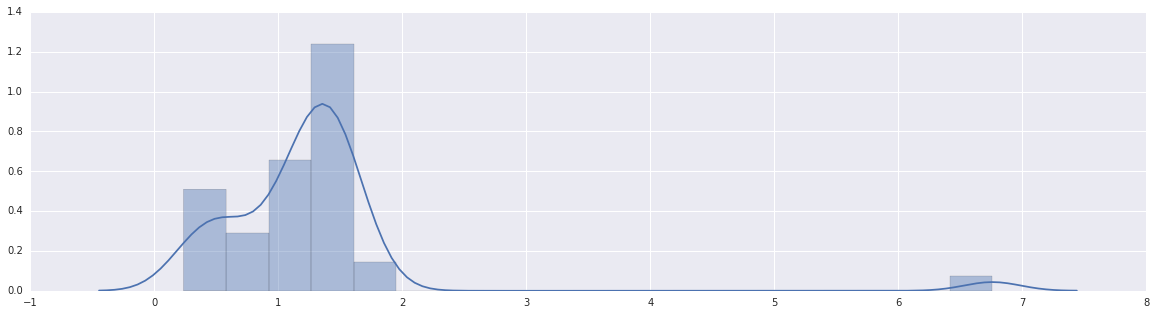

In [1010]:
prs = [math.log1p(x['first.post.age']) for x in first_rankings if x['post.origin']=='json.file']
print(len(prs))
plt.figure(figsize=(20,5))
post_ages = prs
sns.distplot(post_ages)
plt.show()

502


/home/nathan/3venv/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


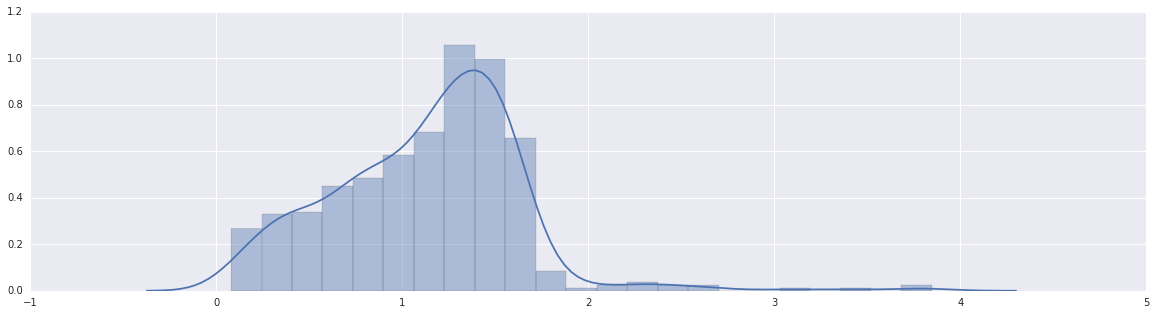

In [1011]:
prs = [math.log1p(x['first.post.age']) for x in first_rankings if x['post.origin']=='experiment.thing']
print(len(prs))
plt.figure(figsize=(20,5))
post_ages = prs
sns.distplot(post_ages)
plt.show()

# Merge Moderation Actions with Rankings

In [1016]:
not_visible_rankings = 0
total_rankings = 0
for key, post in all_posts.items():
    actions = []
    if(key in post_mod_actions.keys()):
        actions = post_mod_actions[key]
    
    ## IF THERE ARE MODERATION ACTIONS:
    if(len(actions)>0):
        visibility = True
        next_pointer = 0
        next_pointer_time = actions[next_pointer]['created']
        
        for ranking in post['rankings']:
            if(ranking['created_at'] > next_pointer_time):
                visibility = actions[next_pointer]['action'] != 'removelink'
                if(next_pointer + 1 < len(actions)):
                    next_pointer += 1
                    next_pointer_time = actions[next_pointer]['created']

            ranking['post.visibility'] = visibility
            if(visibility==False):
                not_visible_rankings += 1
    else:
        for ranking in post['rankings']:
            ranking['post.visibility'] = True
            
    total_rankings += len(post['rankings'])

print("Marked {0} rankings not visible out of {1} rankings.".format(not_visible_rankings, total_rankings))

Marked 59052 rankings not visible out of 192675 rankings.


## Add Experiment Condition to Post Rankings

In [1028]:
posts_in_experiment = 0

for post in list(all_posts.values()):
    rand_block = None
    treatment = 3 # after the experiment
    rand_num = None
    
    if "metadata_json" in post.keys():
        metadata = json.loads(post['metadata_json'])
        rand_block = metadata['randomization']['block.id']
        treatment = int(metadata['randomization']['treatment'])
        rand_num = int(metadata['randomization'][''])
        posts_in_experiment += 1
        
    for ranking in post['rankings']:
        ranking['treatment'] = treatment
        ranking['rand.block'] = rand_block
        ranking['rand.num'] = rand_num
        
print("Found {0} posts in experiment out of {1}".format(posts_in_experiment, len(all_posts)))
    

Found 1273 posts in experiment out of 2791


### Create a dataset of rankings

In [1029]:
all_rankings = []
post_count = 0
for post in all_posts.values():
    post_count += 1
    try:
        post_created = utc.localize(post['created'])
        post['created'] = post_created
    except:
        post_created = post['created']
    
    if(post_created < three_hundred_begin_date):
        continue
    
    for ranking in post['rankings']:
        ranking['post.created'] = post_created
        all_rankings.append(ranking)
print("Created {0} rankings for {1} posts at an average of {2} rankings per post".format(
    len(all_rankings),
    post_count,
    len(all_rankings)/post_count))

Created 192675 rankings for 2791 posts at an average of 69.03439627373702 rankings per post


In [1030]:
len([x for x in all_rankings if 'snapshot.number' in x.keys() and x['snapshot.number']==3])

1835

In [1031]:
#sum([x for x in all_rankings if 'treatment' not in x.keys()])

In [1032]:
#all_rankings[1000]

In [1033]:
pd.DataFrame(all_rankings).to_csv("outputs/r_worldnews_300_rankings_with_post_experiment-02.16.2018.csv")